In [2]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model

In [5]:
def download_data(tickers, start, end):
    data = yf.download(tickers=tickers, start = start, end = end)["Adj Close"]
    data = pd.DataFrame(
        np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns
    )
    data = data.dropna(axis=0)
    return data

In [6]:
data = download_data(tickers=["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31")

[*********************100%%**********************]  6 of 6 completed


In [82]:
def predict_next_period(data):
    garch_models = {}
    for column in data.columns:
        garch_models[column] = dict()
        am = arch_model(data[column], vol="Garch", p=1, o=0, q=1, dist="normal", mean="zero").fit()
        z = am.resid/am.conditional_volatility 
        u = am.model.distribution.cdf(z)
        garch_models[column]['arch_model'] = am
        garch_models[column]['z'] = z
        garch_models[column]['u'] = u
    return garch_models

In [83]:
test123 = predict_next_period(data=data)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4154.546367813942
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5159.561170973338
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4020.9866944285923
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3996.083349274809
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3982.62238266228
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3982.6203187633946
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3982.6203007505396
Iteration:      8,   Func. Count:     39,   Neg. LLF: 3982.6203007505874
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3982.6203007505396
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1157424375.5130973
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5358.070503318815
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3837.194018292

In [87]:
u_data = pd.DataFrame()
for ticker in test123.keys():
    
    test123[ticker]['u']

In [90]:
u_data['test'] = 13

In [91]:
u_data

,test


In [ ]:
copula = GaussianCopula()
copula.fit_corr_param(pd.DataFrame([u1,u2]).T)
sim_data = copula.rvs(1000)

In [9]:
am1 = arch_model(data['AAPL'], vol="Garch", p=1, o=0, q=1, dist="normal", mean="zero").fit()
am2 = arch_model(data['DBK.DE'], vol="Garch", p=1, o=0, q=1, dist="normal", mean="zero").fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4154.546367813942
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5159.561170973338
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4020.9866944285923
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3996.083349274809
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3982.62238266228
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3982.6203187633946
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3982.6203007505396
Iteration:      8,   Func. Count:     39,   Neg. LLF: 3982.6203007505874
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3982.6203007505396
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1170259707.5654743
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6039.537780871488
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4655.405946993

In [11]:
z_1 = am1.resid/am1.conditional_volatility
z_2 = am2.resid/am2.conditional_volatility

$x_t = \sigma_t \epsilon_t\\
\sigma_t² = a_0 + a_1 x_{t-1}² + b_1 \sigma_{t-1}²$

In [13]:
u1 = am1.model.distribution.cdf(z_1)
u2 = am2.model.distribution.cdf(z_2)

In [29]:
from statsmodels.distributions.copula.api import GaussianCopula

In [ ]:
copula = GaussianCopula()
copula.fit_corr_param(pd.DataFrame([u1,u2]).T)
sim_data = copula.rvs(1000)

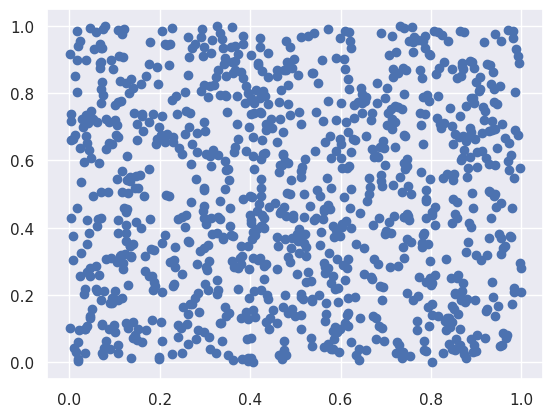

In [42]:
plt.scatter(x=sim_data[:,0], y = sim_data[:,1])

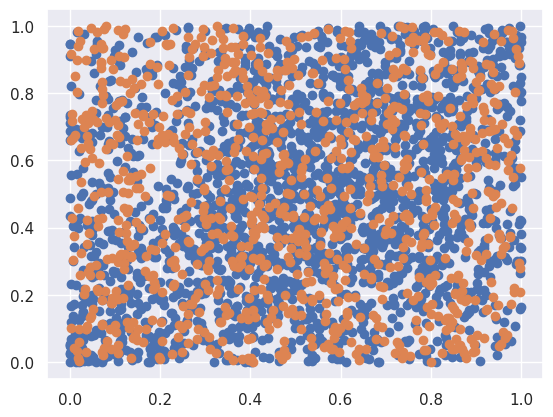

In [44]:
plt.scatter(x = u1, y = u2)
plt.scatter(x=sim_data[:,0], y = sim_data[:,1])

In [45]:
z_1_sim = am1.model.distribution.ppf(sim_data[:,0])
z_2_sim = am2.model.distribution.ppf(sim_data[:,1])

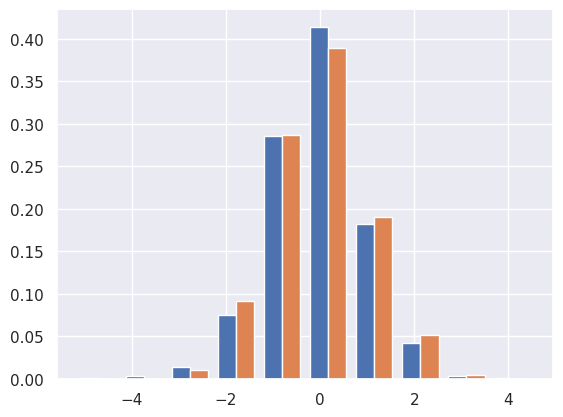

In [48]:
plt.hist([z_2, z_2_sim], density=True);

$x_t = \sigma_t \epsilon_t\\
\sigma_t² = a_0 + a_1 x_{t-1}² + b_1 \sigma_{t-1}²$

epsilon = copula werte

In [53]:
sigma_t1 = np.sqrt(am1.params['omega'] + am1.params['alpha[1]'] * np.square(data['AAPL'].iloc[-1]) + am1.params['beta[1]'] * np.square(am1._volatility[-1]))

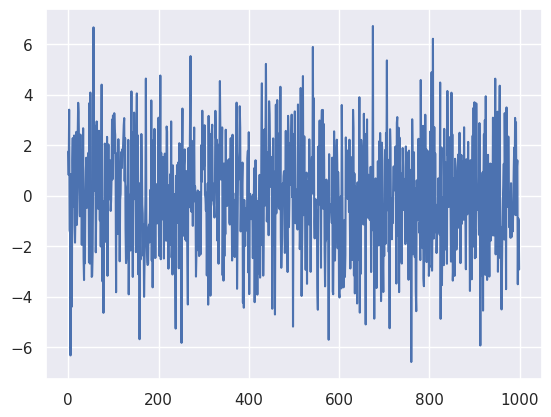

In [56]:
plt.plot(sigma_t1*z_1_sim)

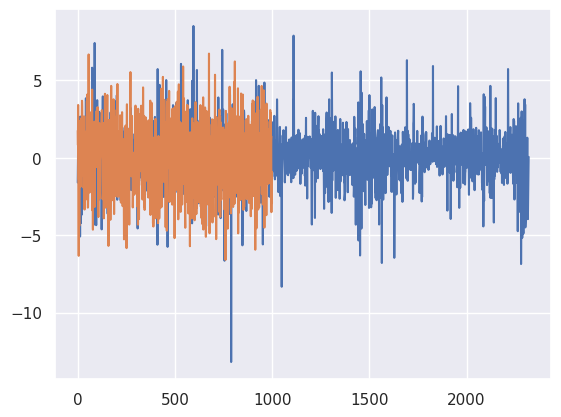

In [58]:
plt.plot(data['AAPL'])
plt.plot(sigma_t1*z_1_sim)

In [50]:
np.sqrt(5.51)

np.float64(2.3473389188611002)

In [125]:
am1._volatility

array([1.83802635, 1.80036152, 1.68767119, ..., 2.05998181, 2.09283441,
       2.34852293])

In [106]:
data['AAPL'].iloc[-1]

np.float64(0.0512405693638307)

In [103]:
data['AAPL']

0      -1.603440
1      -0.185024
2       0.662659
3      -0.886088
4      -1.144027
          ...   
2312    1.290892
2313   -3.168847
2314   -2.555870
2315   -3.967204
2319    0.051241
Name: AAPL, Length: 2134, dtype: float64

In [23]:
import statsmodels

In [24]:
import statsmodels.distributions
import statsmodels.distributions.copula
import statsmodels.distributions.copula.copulas
import statsmodels.distributions.copula.elliptical



In [25]:
test = statsmodels.distributions.copula.elliptical.Copula

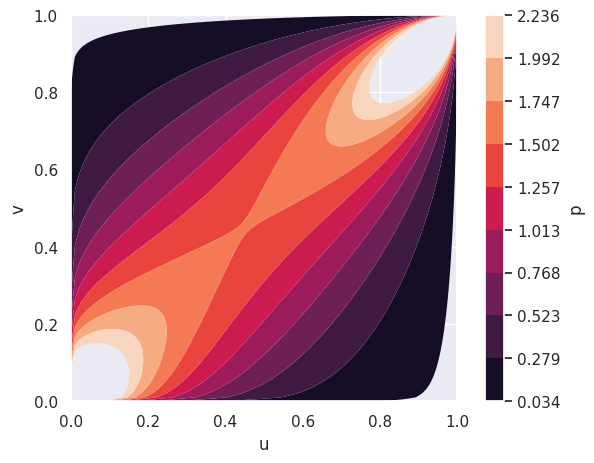

In [27]:
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, IndependenceCopula, GaussianCopula)

copula = GumbelCopula(theta=2)
_ = copula.plot_pdf()

In [28]:
test = GaussianCopula()

In [185]:
np.random.multivariate_normal(mean = [0,0], cov=[[2,1],[1,3]], size=1000)

array([[-1.0892422 , -0.78696187],
       [ 1.44634351,  0.60095894],
       [ 0.17117442, -0.32741743],
       ...,
       [-0.04702449, -0.06495741],
       [ 0.5399015 ,  0.44233153],
       [ 0.3627284 ,  0.96327193]])

In [29]:
test.fit_corr_param([res1,res2])

array([[1., 1.],
       [1., 1.]])

In [37]:
test.distr_mv()

TypeError: 'multivariate_normal_frozen' object is not callable

ValueError: Contour levels must be increasing

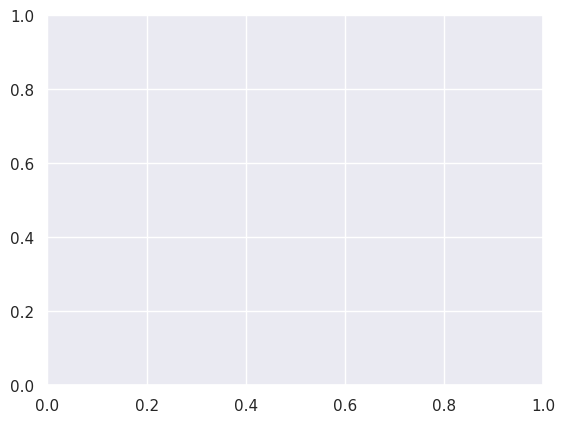

In [38]:
test.plot_pdf()

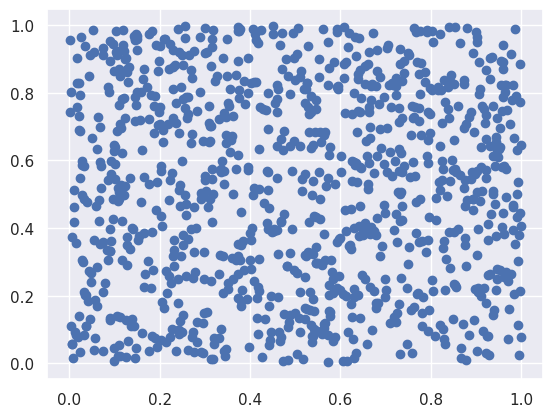

In [187]:
plt.scatter(test.rvs(1000)[:,0], test.rvs(1000)[:,1])

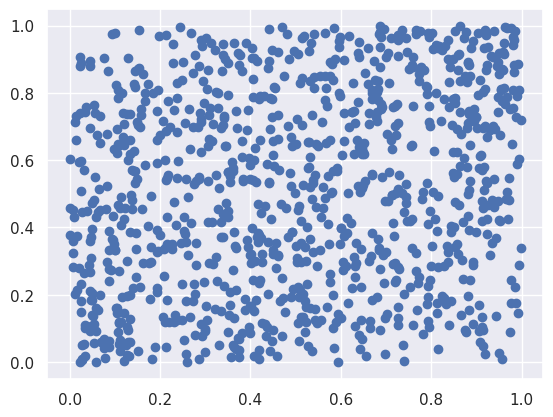

In [168]:
plt.scatter(u1,u2)

Old

In [39]:
df = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31") #"GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"

[*********************100%%**********************]  6 of 6 completed


In [40]:
df.head()

Price      Adj Close                                                         \
Ticker          AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2010-01-04  6.461976  22.495085  16.732595  30.337307  15.592496  38.330063   
2010-01-05  6.473149  22.154026  16.868336  30.826817  15.523831  38.085506   
2010-01-06  6.370184  22.294462  17.129379  30.504465  15.132495  38.013241   
2010-01-07  6.358408  22.146502  17.280773  30.641766  14.780218  37.852051   
2010-01-08  6.400680  22.078793  17.048454  31.758070  14.977255  37.796471   

Price          Close                                   ...       Open  \
Ticker          AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   
2010-01-08  7.570714  44.020000  32.654999  41.323200  ...  33.334999   

Price                                             Volume             \
Ticker         DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   
2010-01-08  40.740635  14.744733  68.133118  447610800.0  3307737.0   

Price                                                      
Ticker         BMW.DE      DBK.DE         GOOG     RWE.DE  
Date                                                       
2010-01-04  1808170.0   4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0   5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0   5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0   4506202.0  257533695.0  1765257.0  
2010-01-08  1925894.0  10753806.0  189680313.0  1665122.0  

[5 rows x 36 columns]

In [41]:
df = df["Adj Close"]

In [42]:
def logtransform(df):
    df = pd.DataFrame(np.diff(np.log(df[1:]), axis=0), columns=df.columns)
    return df

In [43]:
df = logtransform(df)

In [44]:
df = 100 * df

In [45]:
df = df.dropna(axis=0)

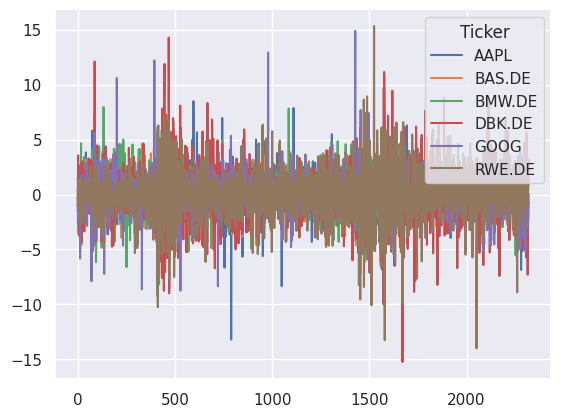

In [46]:
df.plot();

In [47]:
PF = df.mean(axis=1)

In [48]:
df

Ticker,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,-1.603440,0.631907,1.535684,-1.051191,-2.553194,-0.189926
1,-0.185032,-0.665878,0.879943,0.449090,-2.355474,-0.424938
2,0.662622,-0.306200,-1.353496,3.578290,1.324303,-0.146943
3,-0.886051,-1.119398,-1.496366,-1.210307,-0.151272,1.169593
4,-1.144042,-3.625694,-2.949491,-2.621574,-1.784225,-1.022650
...,...,...,...,...,...,...
2312,1.290882,0.370683,-0.718791,-0.209104,1.191078,-1.091217
2313,-3.168837,1.469143,-0.027226,-1.502592,-0.555632,0.936063
2314,-2.555860,-0.982605,-2.216357,-7.298494,-1.338331,-0.857720
2315,-3.967266,1.610404,0.125209,0.598210,-3.003820,-0.313704


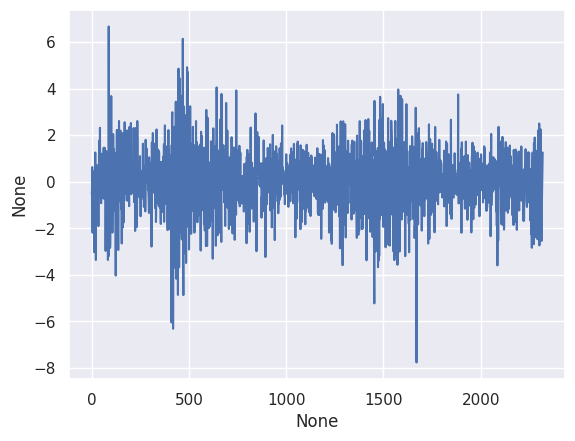

In [49]:
sns.lineplot(x = PF.index, y = PF);

GARCH

Estimate GARCH models for each return series $j=1,...,K$ and $t=1,..,T$

$r_{t,j} = \mu_{j}  + \epsilon_{t,j}$

$\epsilon_{t,j} = \sigma_{t,j} Z_{t,j} $


${\sigma_{t,j}}^2 = \omega_j +  \alpha_{k,j} r_{t-1,j}^2 + \beta_{k,j} \sigma_{t-1,j}^2$ 

$Z_{t,j}$ as assumed innovation distribution and standardized residuals as 

$\hat{z}_{t,j} = \frac{1}{\hat{\sigma}_{t,j}} \Bigl(  r_{t,j} - \hat{\mu}_j       \Bigr)$


In [50]:
def fit_copula(copula_data):
    copula = pv.Vinecop(copula_data.to_numpy())
    return copula

In [51]:
def fit_garch(data):
    am = arch_model(data, vol="Garch", p=1, o=0, q=1, dist="skewt", mean="constant")
    am_fitted = am.fit()

    return am, am_fitted


In [52]:
def transform_simulated_copula_data(data, am, am_fitted):
    return am.distribution.ppf(pits=data,parameters=am_fitted.params[-2:])

In [53]:
def sigma2_forecast(data, am_fitted):
    omega_t = am_fitted.params["omega"]
    alpha_t = am_fitted.params["alpha[1]"]
    beta_t = am_fitted.params["beta[1]"]
    sigma_t1 = omega_t + alpha_t * (data.iloc[-1])**2 + beta_t * am_fitted._volatility[-1]
    return sigma_t1**2

In [54]:
# return series forecasts
def get_series_forecast(sigma2_pred, am_fitted, transformed_data):
    mu = am_fitted.params["mu"]
    res = mu + sigma2_pred*transformed_data
    res = res.sort_values(ascending=True, ignore_index=True)

    return res

In [55]:
def make_forecast(df):
    std_resid_df = pd.DataFrame()
    copula_data_df = pd.DataFrame()
    garch_models = []
    for i in range(0, df.shape[1]):
        am, am_fitted = fit_garch(df.iloc[:,i])
        garch_models.append([am, am_fitted])
        std_resid = am_fitted.resid / am_fitted.conditional_volatility
        std_resid_df[i] = std_resid
        copula_data = am.distribution.cdf(std_resid, parameters=am_fitted.params[-2:])
        copula_data_df[i] = copula_data
    copula = fit_copula(copula_data_df)
    simulated_copula_data = pd.DataFrame(copula.simulate(1000))
    transformed_data = pd.DataFrame()
    for i in range(0, simulated_copula_data.shape[1]):
        am = garch_models[i][0]
        am_fitted = garch_models[i][1]
        transformed_data[i] = transform_simulated_copula_data(data=simulated_copula_data.iloc[:,i], am = am, am_fitted=am_fitted)
        
    sigma2_forecasts = pd.Series()
    for i in range(0, df.shape[1]):
        sigma2 = sigma2_forecast(data=df.iloc[:,i], am_fitted=garch_models[i][1])
        print(sigma2)
        sigma2_forecasts[i] = sigma2

    series_forecasts = pd.DataFrame()
    for i in range(0, df.shape[1]):
        series_forecasts[i] = get_series_forecast(sigma2_pred=sigma2_forecasts[i], am_fitted=garch_models[i][1], transformed_data=transformed_data[i])


    return series_forecasts.iloc[int(series_forecasts.shape[0]*0.01),:].mean()

    

In [56]:
pf_forecasts = pd.Series()

In [57]:
for i in range(0,10):
    pf_forecasts[i] = make_forecast(df=df.iloc[0+i:499+i,:])

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2001.0050480910247
Iteration:      2,   Func. Count:     17,   Neg. LLF: 19876.77887770197
Iteration:      3,   Func. Count:     26,   Neg. LLF: 31895.268729791635
Iteration:      4,   Func. Count:     35,   Neg. LLF: 937.7733792500028
Iteration:      5,   Func. Count:     44,   Neg. LLF: 1537.0119727884307
Iteration:      6,   Func. Count:     52,   Neg. LLF: 935.7701938269493
Iteration:      7,   Func. Count:     60,   Neg. LLF: 935.9176145439963
Iteration:      8,   Func. Count:     68,   Neg. LLF: 931.2561376849053
Iteration:      9,   Func. Count:     75,   Neg. LLF: 931.2124354869535
Iteration:     10,   Func. Count:     82,   Neg. LLF: 931.2072681933286
Iteration:     11,   Func. Count:     89,   Neg. LLF: 931.2069283007668
Iteration:     12,   Func. Count:     96,   Neg. LLF: 931.2068996815344
Iteration:     13,   Func. Count:    102,   Neg. LLF: 931.2068996815549
Optimization terminated successfully    (Exit mode 0)
       

In [58]:
pf_forecasts

0   -16.236691
1   -11.168210
2   -22.373900
3   -12.065977
4   -13.130797
5   -12.483234
6   -11.394159
7   -10.845552
8   -14.537670
9   -14.119739
dtype: float64

In [59]:
pf_actual = pd.Series(PF[500:600]).reset_index(drop=True)

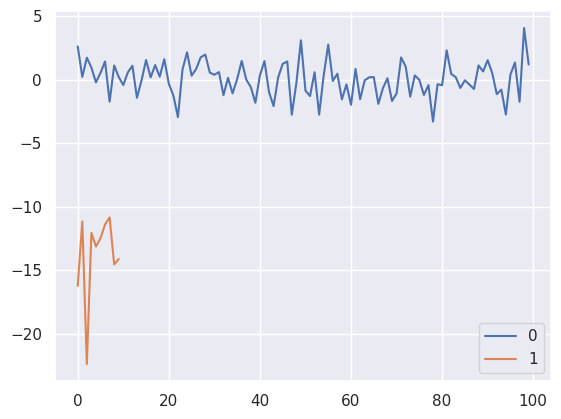

In [60]:
pd.DataFrame([pf_actual, pf_forecasts]).T.plot();